In [1]:
import pandas as pd
from darts import TimeSeries

In [3]:
#df = pd.read_csv(r"C:\Users\jakob\Downloads\archive (1)\AirPassengers.csv")

ab_df = pd.read_csv('../../data/interim/absences_per_day.csv', sep=',')
ab_df

,index,count,day_of_week,month,season
0,2020-01-02,2,3,1,1
1,2020-01-03,2,4,1,1
2,2020-01-04,2,5,1,1
3,2020-01-05,1,6,1,1
4,2020-01-06,1,0,1,1
...,...,...,...,...,...
1453,2023-12-25,60,0,12,4
1454,2023-12-26,60,1,12,4
1455,2023-12-27,213,2,12,4
1456,2023-12-28,211,3,12,4


In [4]:
ab_df = ab_df[['index', 'count']]
# drop all rows with index older than 2023-03-01
ab_df = ab_df.drop(ab_df[ab_df['index'] > '2023-03-01'].index)
# normalize data   
ab_df['count'] = ab_df['count'] / ab_df['count'].max()
ab_df


,index,count
0,2020-01-02,0.004082
1,2020-01-03,0.004082
2,2020-01-04,0.004082
3,2020-01-05,0.002041
4,2020-01-06,0.002041
...,...,...
1150,2023-02-25,0.440816
1151,2023-02-26,0.138776
1152,2023-02-27,0.232653
1153,2023-02-28,0.234694


In [5]:
#series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')
#series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')
#series
#creaet new dataframe with only date and count
ab_df['index'] = pd.to_datetime(ab_df['index'])

series = TimeSeries.from_dataframe(ab_df, 'index', 'count')
series

<TimeSeries (DataArray) (index: 1155, component: 1, sample: 1)>
array([[[0.00408163]],

       [[0.00408163]],

       [[0.00408163]],

       ...,

       [[0.23265306]],

       [[0.23469388]],

       [[0.21632653]]])
Coordinates:
  * index      (index) datetime64[ns] 2020-01-02 2020-01-03 ... 2023-03-01
  * component  (component) object 'count'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [6]:
from darts.models import ExponentialSmoothing

train, val = series.split_before(pd.Timestamp('20220701'))

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val))

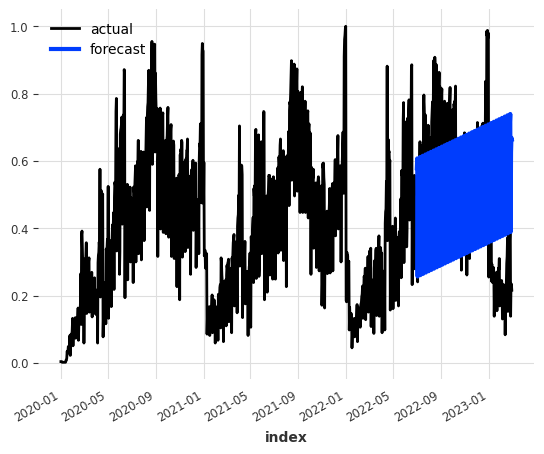

In [7]:
import matplotlib.pyplot as plt

series.plot(label='actual')
prediction.plot(label='forecast', lw=3)
plt.legend()


In [10]:
from darts.models import Prophet

models = [ExponentialSmoothing(), Prophet()]

backtests = [model.historical_forecasts(series,
                            start=.7,
                            forecast_horizon=3)
             for model in models]

15:04:25 - cmdstanpy - INFO - Chain [1] start processing
15:04:25 - cmdstanpy - INFO - Chain [1] done processing
15:04:26 - cmdstanpy - INFO - Chain [1] start processing
15:04:26 - cmdstanpy - INFO - Chain [1] done processing
15:04:26 - cmdstanpy - INFO - Chain [1] start processing
15:04:26 - cmdstanpy - INFO - Chain [1] done processing
15:04:26 - cmdstanpy - INFO - Chain [1] start processing
15:04:26 - cmdstanpy - INFO - Chain [1] done processing
15:04:27 - cmdstanpy - INFO - Chain [1] start processing
15:04:27 - cmdstanpy - INFO - Chain [1] done processing
15:04:27 - cmdstanpy - INFO - Chain [1] start processing
15:04:27 - cmdstanpy - INFO - Chain [1] done processing
15:04:27 - cmdstanpy - INFO - Chain [1] start processing
15:04:27 - cmdstanpy - INFO - Chain [1] done processing
15:04:28 - cmdstanpy - INFO - Chain [1] start processing
15:04:28 - cmdstanpy - INFO - Chain [1] done processing
15:04:28 - cmdstanpy - INFO - Chain [1] start processing
15:04:28 - cmdstanpy - INFO - Chain [1]

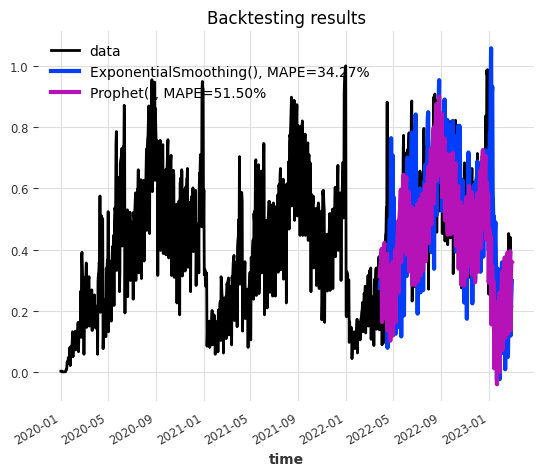

In [12]:
from darts.metrics import mape

series.plot(label='data')
for i, m in enumerate(models):
    err = mape(backtests[i], series)
    backtests[i].plot(lw=3, label='{}, MAPE={:.2f}%'.format(m, err))

plt.title('Backtesting results')
plt.legend()